In [6]:
import pandas as pd

# Define the path to your local dataset files
data_path = "D:/archive (1)/CheXpert-v1.0-small/train.csv"
valid_path = "D:/archive (1)/CheXpert-v1.0-small/valid.csv"

# Read the CSV files into DataFrames
data = pd.read_csv(data_path)
valid = pd.read_csv(valid_path)

# Replace empty strings, spaces, and NaN values with 0
data = data.replace(['', ' '], 0).fillna(0)
valid = valid.replace(['', ' '], 0).fillna(0)

# Display the first few rows to understand the data structure
print(data.head())


                                                Path     Sex  Age  \
0  CheXpert-v1.0-small/train/patient00001/study1/...  Female   68   
1  CheXpert-v1.0-small/train/patient00002/study2/...  Female   87   
2  CheXpert-v1.0-small/train/patient00002/study1/...  Female   83   
3  CheXpert-v1.0-small/train/patient00002/study1/...  Female   83   
4  CheXpert-v1.0-small/train/patient00003/study1/...    Male   41   

  Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  Cardiomegaly  \
0         Frontal    AP         1.0                         0.0           0.0   
1         Frontal    AP         0.0                         0.0          -1.0   
2         Frontal    AP         0.0                         0.0           0.0   
3         Lateral     0         0.0                         0.0           0.0   
4         Frontal    AP         0.0                         0.0           0.0   

   Lung Opacity  Lung Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
0           0.0     

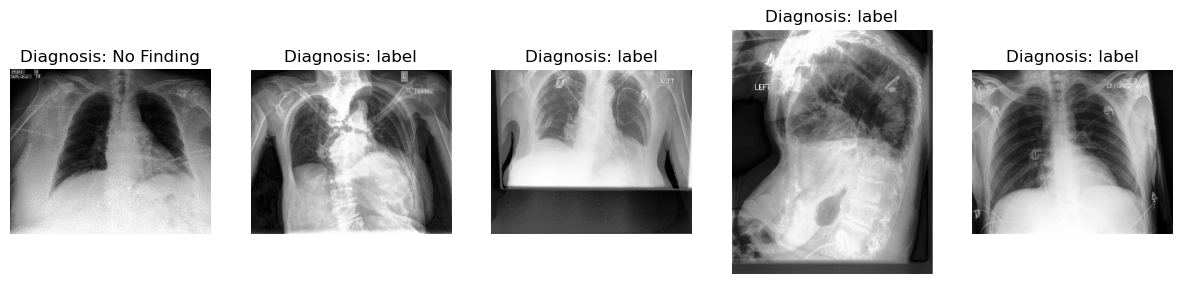

In [63]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def display_images(data, num_images=5):
    plt.figure(figsize=(15, 10))

    # Define the root directory for the image files (local path)
    root_dir = "D:/archive (1)/"

    for i in range(num_images):
        # Get the relative image path from the DataFrame and combine it with the root directory
        img_path = os.path.join(root_dir, data['Path'].iloc[i])  # Combine root and relative path
        diagnoses = data.iloc[i, 1:].to_dict()  # Get the diagnosis columns

        # Load and display the image
        try:
            img = Image.open(img_path).convert("RGB")
            plt.subplot(1, num_images, i + 1)
            plt.imshow(img)
            # Display only the diagnosis columns with a value of 1
            diagnosis_text = ', '.join([k for k, v in diagnoses.items() if v == 1])
            plt.title(f"Diagnosis: {diagnosis_text}" if diagnosis_text else "No Finding")
            plt.axis('off')
        except FileNotFoundError:
            print(f"File not found: {img_path}")

    plt.show()

# Now call the display function
display_images(data, num_images=5)  # Adjust the number of images as needed


In [73]:
import os
import pandas as pd
from PIL import Image
from torchvision import transforms
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import ConcatDataset, Subset
import torch.nn as nn
from torch.optim import Adam
from torchvision import transforms, models
root_dir = "D:/archive (1)/"
# Suppression des espaces dans les noms de colonnes
data.columns = data.columns.str.strip()
valid.columns = valid.columns.str.strip()

# Sélectionner les colonnes pertinentes (Path et No Finding)
diagnosis_columns = ['Path', 'No Finding']
data = data[diagnosis_columns]
valid = valid[diagnosis_columns]

# Suppression des lignes contenant des valeurs manquantes
data.dropna(subset=diagnosis_columns[1:], inplace=True)
valid.dropna(subset=diagnosis_columns[1:], inplace=True)

# Créer une colonne 'label' où 0 indique "non malade" et 1 "malade"
data['label'] = data['No Finding'].apply(lambda x: 0 if x == 1 else 1)
valid['label'] = valid['No Finding'].apply(lambda x: 0 if x == 1 else 1)

# Séparer les données en classes saines et malades
healthy_data = data[data['label'] == 0].sample(20000, random_state=42)  # 20k healthy
sick_data = data[data['label'] == 1].sample(20000, random_state=42)    # 20k sick

healthy_valid = valid[valid['label'] == 0].sample(30, random_state=42)  # 30 healthy
sick_valid = valid[valid['label'] == 1].sample(30, random_state=42)    # 30 sick

# Définir la transformation des images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionner les images à 224x224
    transforms.ToTensor(),  # Convertir l'image en tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation avec les moyennes et écarts-types d'ImageNet
])

# Définir une classe Dataset personnalisée pour charger les images et les labels
class CheXpertDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Récupérer le chemin de l'image
        img_path = os.path.join(root_dir, self.dataframe.iloc[idx]['Path'])

        # Charger l'image
        image = Image.open(img_path).convert("RGB")

        # Appliquer les transformations si définies
        if self.transform:
            image = self.transform(image)

        # Récupérer le label correspondant
        label = self.dataframe.iloc[idx]['label']
        label = torch.tensor(label, dtype=torch.float32)  # Convertir en tensor de type float32

        return image, label

# Créer les datasets pour l'entraînement et la validation
train_dataset = CheXpertDataset(pd.concat([healthy_data, sick_data]), transform=transform)
valid_dataset = CheXpertDataset(pd.concat([healthy_valid, sick_valid]), transform=transform)

# Créer les DataLoader pour charger les données par lot
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Afficher les dimensions des datasets
print(f"Nombre d'exemples dans le jeu d'entraînement : {len(train_dataset)} (20K sains, 20K malades)")
print(f"Nombre d'exemples dans le jeu de validation : {len(valid_dataset)} (30 sains, 30 malades)")



Nombre d'exemples dans le jeu d'entraînement : 40000 (20K sains, 20K malades)
Nombre d'exemples dans le jeu de validation : 60 (30 sains, 30 malades)


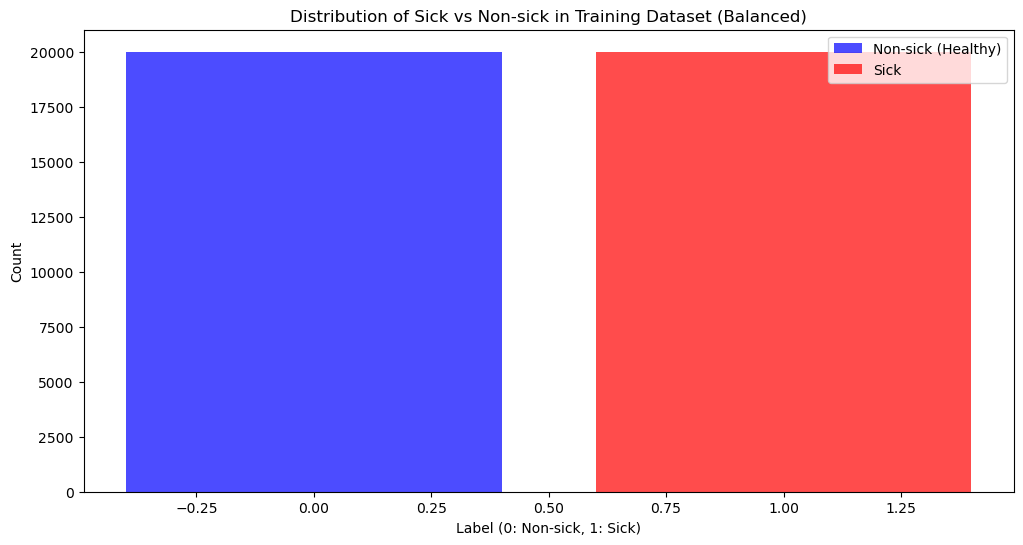

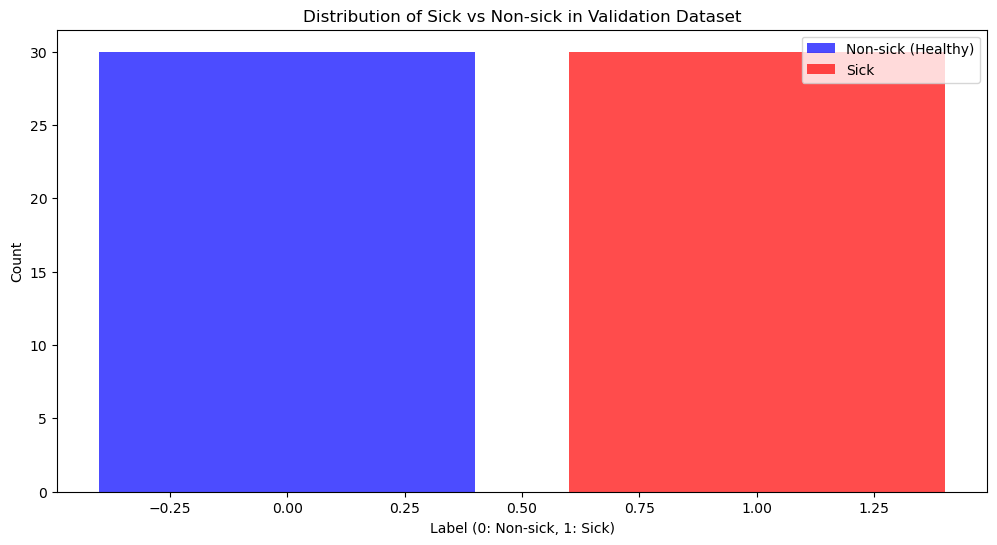

In [67]:
import matplotlib.pyplot as plt
import pandas as pd

# Concatenate the labels from healthy and sick samples for visualization
train_labels = pd.concat([healthy_data, sick_data])['label']
valid_labels = pd.concat([healthy_valid, sick_valid])['label']

# Plot histogram for the training set
plt.figure(figsize=(12, 6))
plt.hist(train_labels[train_labels == 0], bins=1, color='blue', alpha=0.7, label='Non-sick (Healthy)', rwidth=0.8)
plt.hist(train_labels[train_labels == 1], bins=1, color='red', alpha=0.7, label='Sick', rwidth=0.8)
plt.title('Distribution of Sick vs Non-sick in Training Dataset (Balanced)')
plt.xlabel('Label (0: Non-sick, 1: Sick)')
plt.ylabel('Count')
plt.legend()
plt.show()

# Plot histogram for the validation set
plt.figure(figsize=(12, 6))
plt.hist(valid_labels[valid_labels == 0], bins=1, color='blue', alpha=0.7, label='Non-sick (Healthy)', rwidth=0.8)
plt.hist(valid_labels[valid_labels == 1], bins=1, color='red', alpha=0.7, label='Sick', rwidth=0.8)
plt.title('Distribution of Sick vs Non-sick in Validation Dataset')
plt.xlabel('Label (0: Non-sick, 1: Sick)')
plt.ylabel('Count')
plt.legend()
plt.show()


In [78]:
from tqdm import tqdm  # Import tqdm for progress bars

root_dir = "D:/archive (1)/"
# Load pre-trained ResNet18 and modify the final layer
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)  # Binary classification
model = model.to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Training and validation loop
epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    # Wrapping the train_loader with tqdm for progress bar
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training", unit="batch"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.view(-1), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct += (predicted.view(-1) == labels).sum().item()
        total += labels.size(0)
    train_accuracy = correct / total

    # Validation (wrap validation loop with tqdm for progress bar)
    model.eval()
    valid_loss = 0
    valid_correct = 0
    valid_total = 0
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc=f"Epoch {epoch + 1}/{epochs} - Validation", unit="batch"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs.view(-1), labels)
            valid_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            valid_correct += (predicted.view(-1) == labels).sum().item()
            valid_total += labels.size(0)
    valid_accuracy = valid_correct / valid_total

    # Print training and validation results for the epoch
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss / len(train_loader):.4f} | Train Acc: {train_accuracy:.4f}")
    print(f"Valid Loss: {valid_loss / len(valid_loader):.4f} | Valid Acc: {valid_accuracy:.4f}")

# Save the trained model
torch.save(model.state_dict(), "xray_model.pth")
print("Model saved as 'xray_model.pth'.")


D:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 - Validation: 100%|████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.87s/batch]


Epoch 1/10
Train Loss: 0.5210 | Train Acc: 0.7581
Valid Loss: 0.4445 | Valid Acc: 0.7833


Epoch 2/10 - Validation: 100%|████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.50s/batch]


Epoch 2/10
Train Loss: 0.4912 | Train Acc: 0.7748
Valid Loss: 0.4747 | Valid Acc: 0.7833


Epoch 3/10 - Validation: 100%|████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.01s/batch]


Epoch 3/10
Train Loss: 0.4804 | Train Acc: 0.7826
Valid Loss: 0.4994 | Valid Acc: 0.7667


Epoch 4/10 - Validation: 100%|████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.27s/batch]


Epoch 4/10
Train Loss: 0.4699 | Train Acc: 0.7879
Valid Loss: 0.3956 | Valid Acc: 0.8833


Epoch 5/10 - Validation: 100%|████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.21s/batch]


Epoch 5/10
Train Loss: 0.4571 | Train Acc: 0.7970
Valid Loss: 0.3668 | Valid Acc: 0.8667


Epoch 6/10 - Validation: 100%|████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.35s/batch]


Epoch 6/10
Train Loss: 0.4403 | Train Acc: 0.8043
Valid Loss: 0.4267 | Valid Acc: 0.8500


Epoch 7/10 - Validation: 100%|████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.22s/batch]


Epoch 7/10
Train Loss: 0.4113 | Train Acc: 0.8182
Valid Loss: 0.4532 | Valid Acc: 0.8167


Epoch 8/10 - Validation: 100%|████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.04s/batch]


Epoch 8/10
Train Loss: 0.3576 | Train Acc: 0.8460
Valid Loss: 0.4862 | Valid Acc: 0.7833


Epoch 9/10 - Validation: 100%|████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.21s/batch]


Epoch 9/10
Train Loss: 0.2699 | Train Acc: 0.8873
Valid Loss: 0.6062 | Valid Acc: 0.7667


Epoch 10/10 - Validation: 100%|███████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.11s/batch]

Epoch 10/10
Train Loss: 0.1695 | Train Acc: 0.9316
Valid Loss: 0.8754 | Valid Acc: 0.7000
Model saved as 'xray_model.pth'.


In [7]:
import torch
from torchvision import models, transforms
from PIL import Image
import torch.nn as nn

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prediction function
def predict(model_path, img_path):
    # Define image transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    # Load the model
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 1)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()

    # Load and preprocess the image
    image = Image.open(img_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    # Perform the prediction
    with torch.no_grad():
        output = model(image)
        prediction = torch.sigmoid(output).item()
        label = "Positive" if prediction > 0.5 else "Negative"
        print(f"Prediction: {label} (Confidence: {prediction:.4f})")

# Example usage for prediction
predict("xray_model.pth", "D:/augmented_images/aug_4.png")


C:\Users\cheba\AppData\Local\Temp\ipykernel_23952\3426623896.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=d

Prediction: Negative (Confidence: 0.0508)


2024-12-06 08:18:03.808 
  command:

    streamlit run D:\anaconda\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
